<a href="https://www.kaggle.com/code/mohammedmohsen0404/proj28-cv-ships-object-detection-using-yolov8?scriptVersionId=194818148" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>Ships Object Detection using YOLOv8</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---

This project aims to develop efficient ship detection models using a carefully curated dataset of 26.9k annotated images. The dataset, labeled in the YOLO format, focuses exclusively on detecting ships, which has crucial applications in maritime safety, fisheries management, marine pollution monitoring, and maritime security. By leveraging this dataset, researchers can create precise models that contribute to preventing accidents, monitoring fishing activities, and enhancing overall maritime operations.

# **Import Libraries and Data**
---

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

In [2]:
!wandb disabled

W&B disabled.


In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 20.4 MB/s eta 0:00:00


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121
from keras import backend as keras
from ultralytics import YOLO
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
!kaggle datasets download -d siddharthkumarsah/ships-in-aerial-images
!unzip ships-in-aerial-images.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/siddharthkumarsah/ships-in-aerial-images
License(s): CC-BY-SA-4.0
 97%|███████████████████████████████████████▊ | 343M/353M [00:01<00:00, 321MB/s]
100%|█████████████████████████████████████████| 353M/353M [00:01<00:00, 294MB/s]


# **Data Exploration**
----

In [6]:
print('Number of train frames: ' + str(len(os.listdir('ships-aerial-images/train/images'))))
print('Number of train labels: ' + str(len(os.listdir('ships-aerial-images/train/labels'))))
print('Number of val frames: ' + str(len(os.listdir('ships-aerial-images/valid/images'))))
print('Number of val labels: ' + str(len(os.listdir('ships-aerial-images/valid/labels'))))
print('Number of test frames: ' + str(len(os.listdir('ships-aerial-images/test/images'))))
print('Number of test labels: ' + str(len(os.listdir('ships-aerial-images/test/labels'))))
print('Total frames: ' + str(len(os.listdir('ships-aerial-images/train/images')) + len(os.listdir('ships-aerial-images/valid/images')) + len(os.listdir('ships-aerial-images/test/images'))))

Number of train frames: 9697
Number of train labels: 9697
Number of val frames: 2165
Number of val labels: 2165
Number of test frames: 1573
Number of test labels: 1573
Total frames: 13435


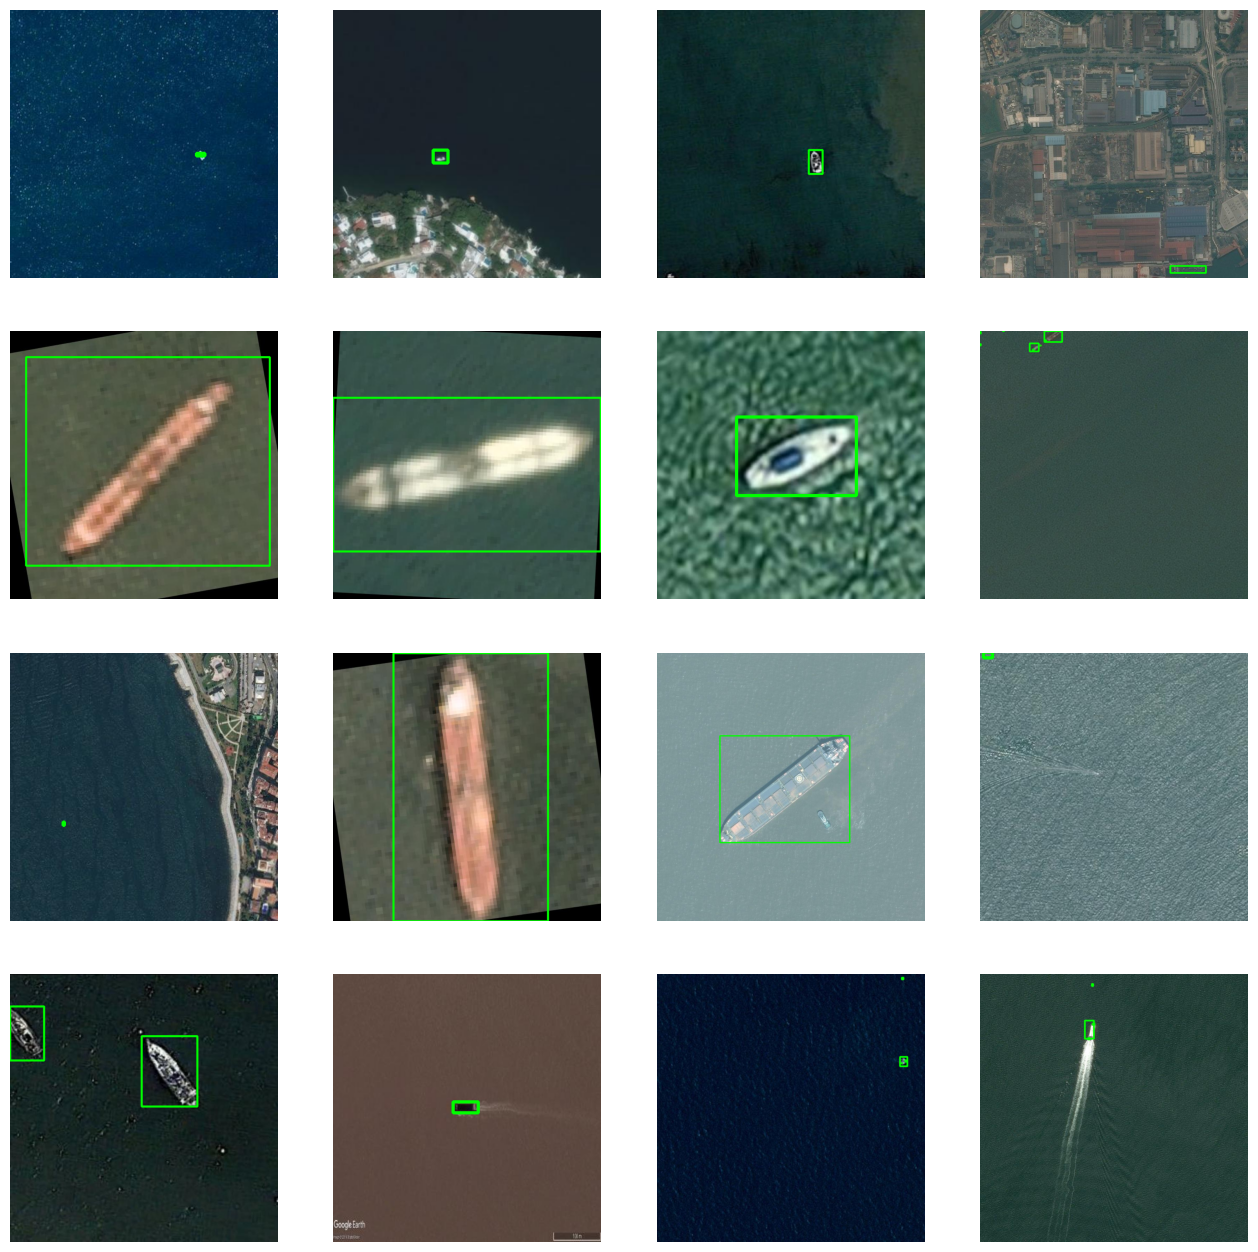

In [7]:
# Define the paths to the images and labels directories
train_images = "ships-aerial-images/train/images"
train_labels = "ships-aerial-images/train/labels"

test_images = "ships-aerial-images/test/images"
test_labels = "ships-aerial-images/test/labels"

val_images = "ships-aerial-images/valid/images"
val_labels = "ships-aerial-images/valid/labels"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [8]:
image = cv2.imread("ships-aerial-images/test/images/02e39612d_jpg.rf.cc5483bb711f080d12b644ff62cf977a.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 768x768 and 3 channels.


# **Modeling**
----

In [9]:
 # Loading a pretrained model
model = YOLO('yolov8s.pt')

# Training the model
model.train(data = '/kaggle/input/ships-in-aerial-images/ships-aerial-images/data.yaml',
            epochs = 10,
            imgsz = height,
            seed = 42,
            batch = 8,
            workers = 4)

100%|██████████| 21.5M/21.5M [00:00<00:00, 109MB/s] 


Ultralytics YOLOv8.2.84 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/input/ships-in-aerial-images/ships-aerial-images/data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=768, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

100%|██████████| 755k/755k [00:00<00:00, 20.7MB/s]
2024-08-31 15:34:09,836	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-31 15:34:10,520	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 99.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/ships-in-aerial-images/ships-aerial-images/train/labels... 9697 images, 351 backgrounds, 2 corrupt: 100%|██████████| 9697/9697 [00:42<00:00, 225.79it/s]

train: WARNING ⚠️ /kaggle/input/ships-in-aerial-images/ships-aerial-images/train/images/1__20180714_180427_1029__-118-20071740708637_33-73029905538088_png.rf.330efa80ecbf49d6ceac7071288d64b4.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0249]
train: WARNING ⚠️ /kaggle/input/ships-in-aerial-images/ships-aerial-images/train/images/1__20180714_180427_1029__-118-21100741654266_33-732092454738826_png.rf.7243f2b58b505e51950850f4b26081ba.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0079]


train: WARNING ⚠️ Cache directory /kaggle/input/ships-in-aerial-images/ships-aerial-images/train is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 709, len(boxes) = 19454. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/ships-in-aerial-images/ships-aerial-images/valid/labels... 2165 images, 68 backgrounds, 0 corrupt: 100%|██████████| 2165/2165 [00:08<00:00, 240.61it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/ships-in-aerial-images/ships-aerial-images/valid is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 172, len(boxes) = 3720. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 768 train, 768 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.

       1/10      3.71G      1.986      3.814      1.856          9        768: 100%|██████████| 1212/1212 [04:51<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:23<00:00,  5.73it/s]


                   all       2165       3720      0.312      0.195      0.164     0.0719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.34G      1.962      2.061      1.831          6        768: 100%|██████████| 1212/1212 [04:43<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:22<00:00,  5.95it/s]

                   all       2165       3720      0.361      0.233      0.233      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.49G      1.861       1.88      1.752         12        768: 100%|██████████| 1212/1212 [04:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:22<00:00,  5.93it/s]


                   all       2165       3720      0.336      0.263      0.258       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       3.9G      1.772      1.742       1.66          8        768: 100%|██████████| 1212/1212 [04:41<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:22<00:00,  5.94it/s]

                   all       2165       3720      0.396      0.273      0.261      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.37G      1.674       1.61      1.589          7        768: 100%|██████████| 1212/1212 [04:41<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:22<00:00,  5.95it/s]

                   all       2165       3720      0.483      0.323      0.346      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.52G      1.603      1.501      1.532          6        768: 100%|██████████| 1212/1212 [04:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:22<00:00,  6.04it/s]

                   all       2165       3720      0.419      0.314      0.331      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       3.6G      1.551      1.397       1.49         15        768: 100%|██████████| 1212/1212 [04:39<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:22<00:00,  6.00it/s]

                   all       2165       3720      0.499      0.371      0.384      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.37G      1.506      1.327      1.455          7        768: 100%|██████████| 1212/1212 [04:39<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:22<00:00,  6.03it/s]

                   all       2165       3720      0.501      0.383      0.398      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.84G      1.459      1.271      1.423          7        768: 100%|██████████| 1212/1212 [04:39<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:22<00:00,  6.03it/s]

                   all       2165       3720      0.511       0.39      0.406       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.68G      1.398      1.185      1.376         13        768: 100%|██████████| 1212/1212 [04:39<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:22<00:00,  6.01it/s]

                   all       2165       3720      0.525      0.405      0.424      0.245



10 epochs completed in 0.851 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.84 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:24<00:00,  5.59it/s]


                   all       2165       3720      0.525      0.405      0.424      0.245
Speed: 0.2ms preprocess, 6.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fc1e4466050>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

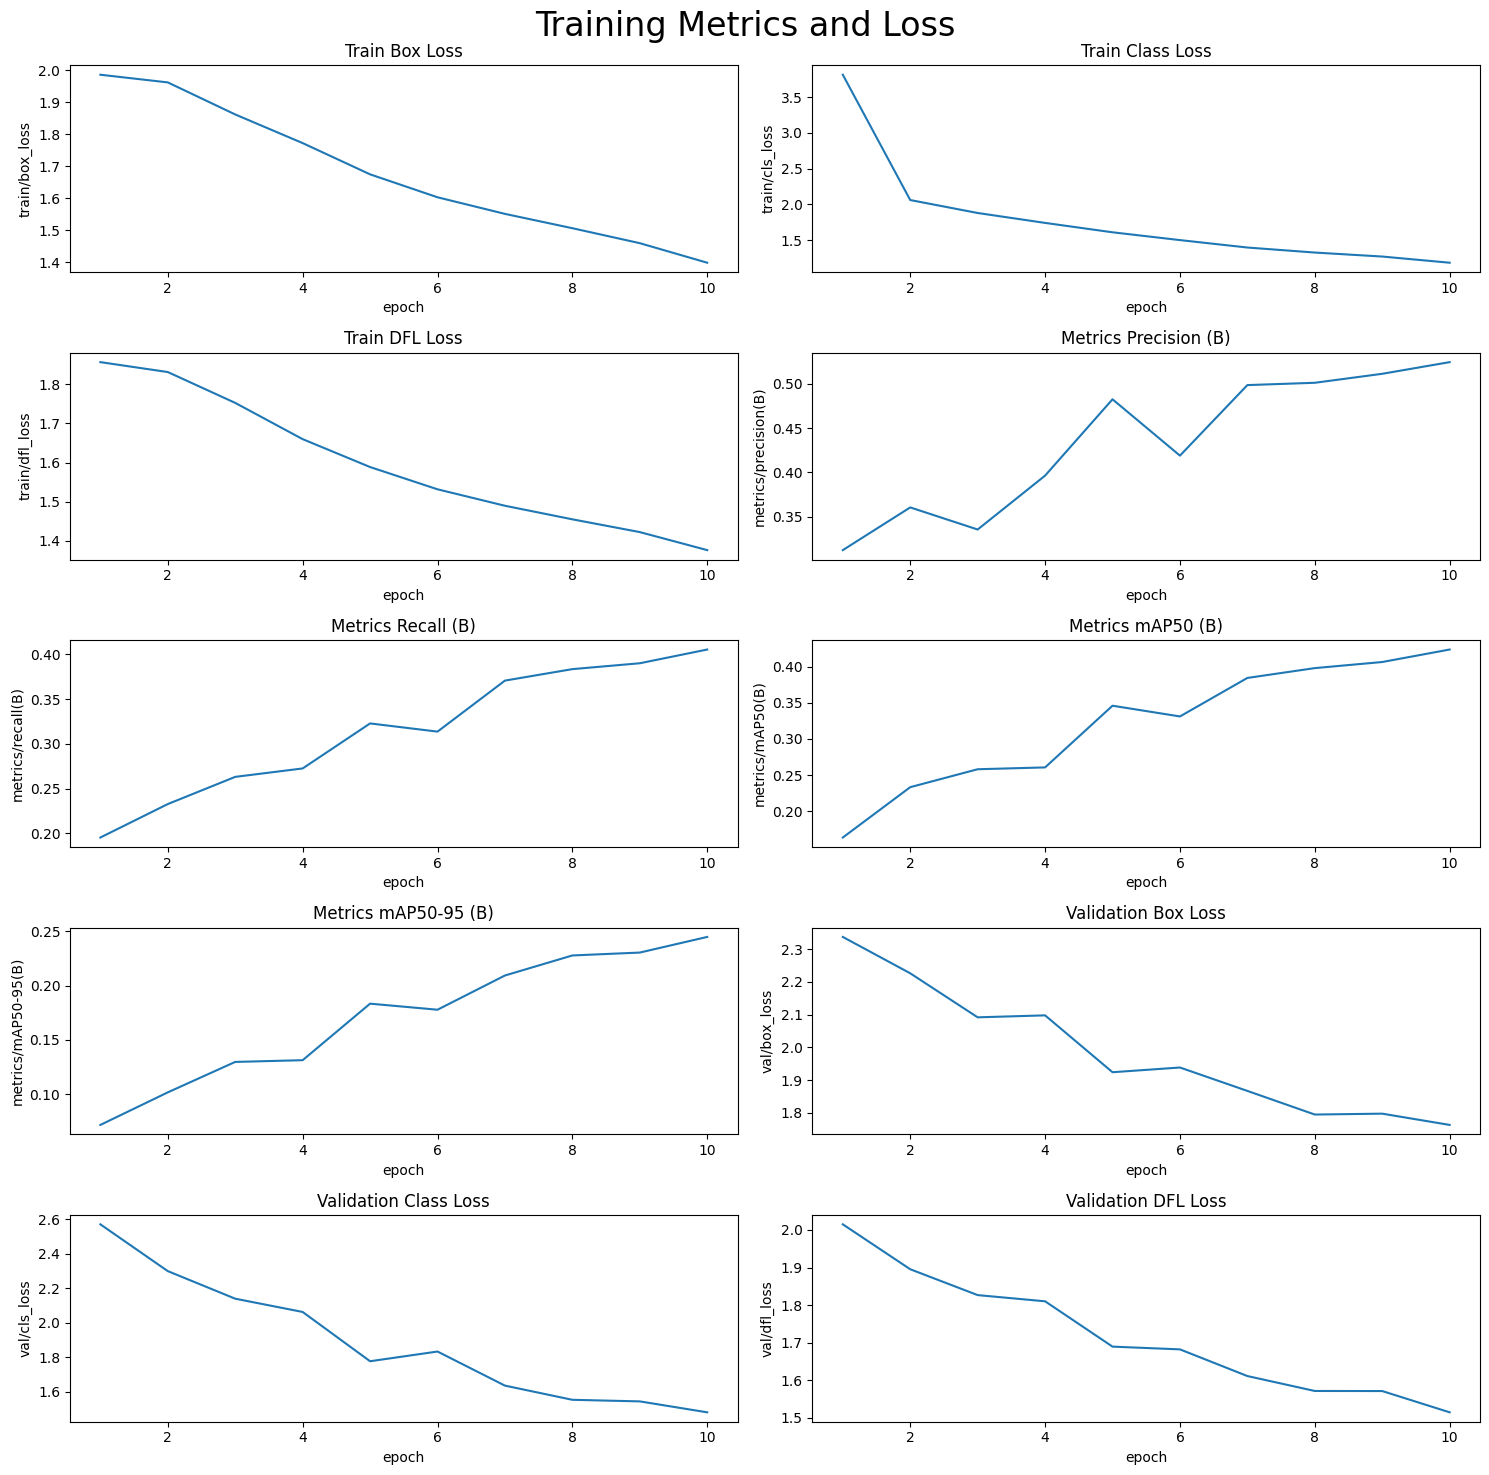

In [10]:
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# **Evaluation**
----

In [11]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics YOLOv8.2.84 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/input/ships-in-aerial-images/ships-aerial-images/test/labels... 1573 images, 51 backgrounds, 0 corrupt: 100%|██████████| 1573/1573 [00:06<00:00, 238.88it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/ships-in-aerial-images/ships-aerial-images/test is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 106, len(boxes) = 2872. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:18<00:00,  5.31it/s]


                   all       1573       2872      0.688      0.264      0.494      0.328
Speed: 0.2ms preprocess, 7.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val


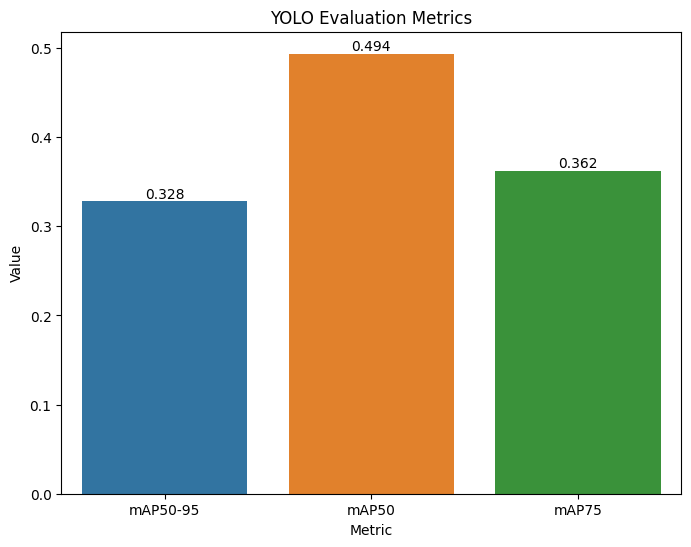

In [12]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

**Confusion Matrix**

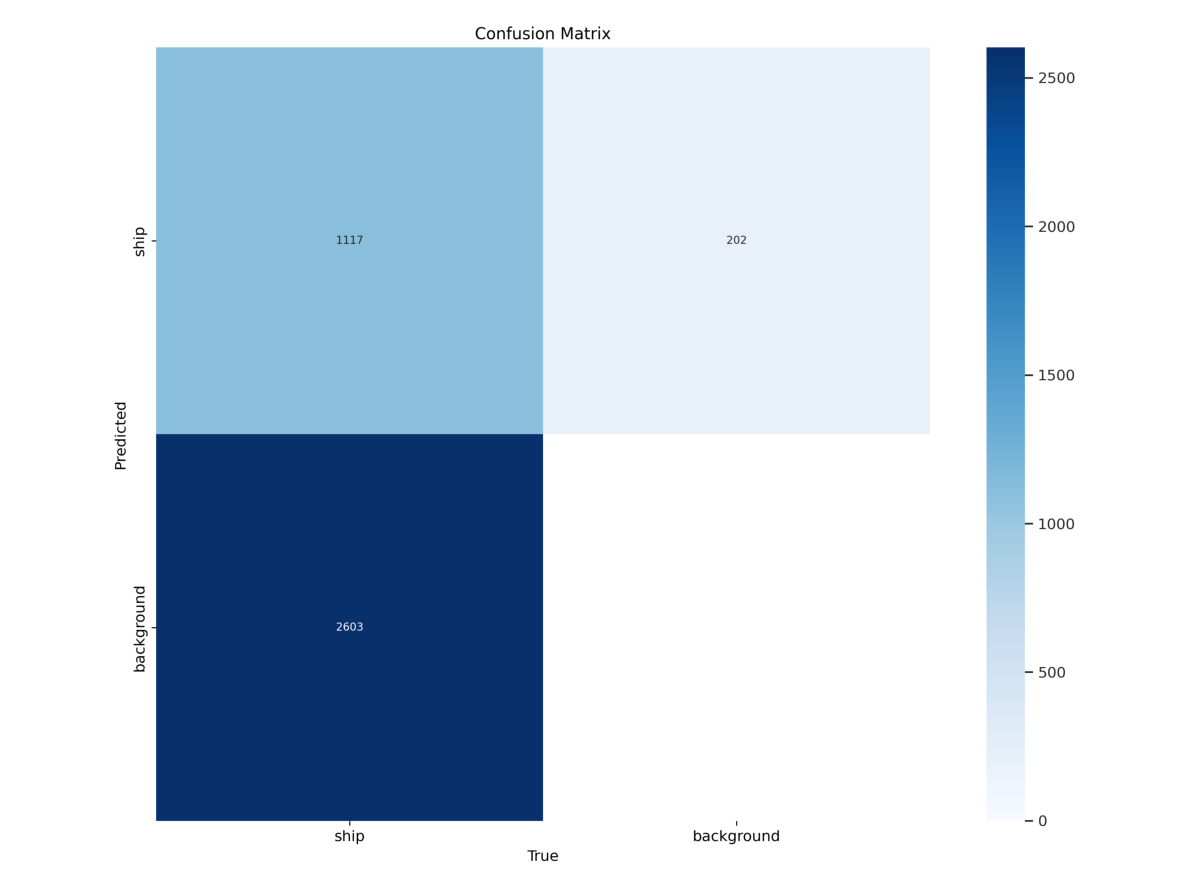

In [13]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

# **Making Predictions on Test Images**
---

In [14]:
#Function to perform ship detections
def ship_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 768x768 1 ship, 10.0ms
Speed: 5.6ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 768)

0: 768x768 1 ship, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 768)

0: 768x768 (no detections), 10.0ms
Speed: 3.6ms preprocess, 10.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 768)

0: 768x768 3 ships, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 768)

0: 768x768 1 ship, 10.0ms
Speed: 3.5ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 768)

0: 768x768 1 ship, 10.0ms
Speed: 4.1ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 768)

0: 768x768 1 ship, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 768)

0: 768x768 1 ship, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 768)


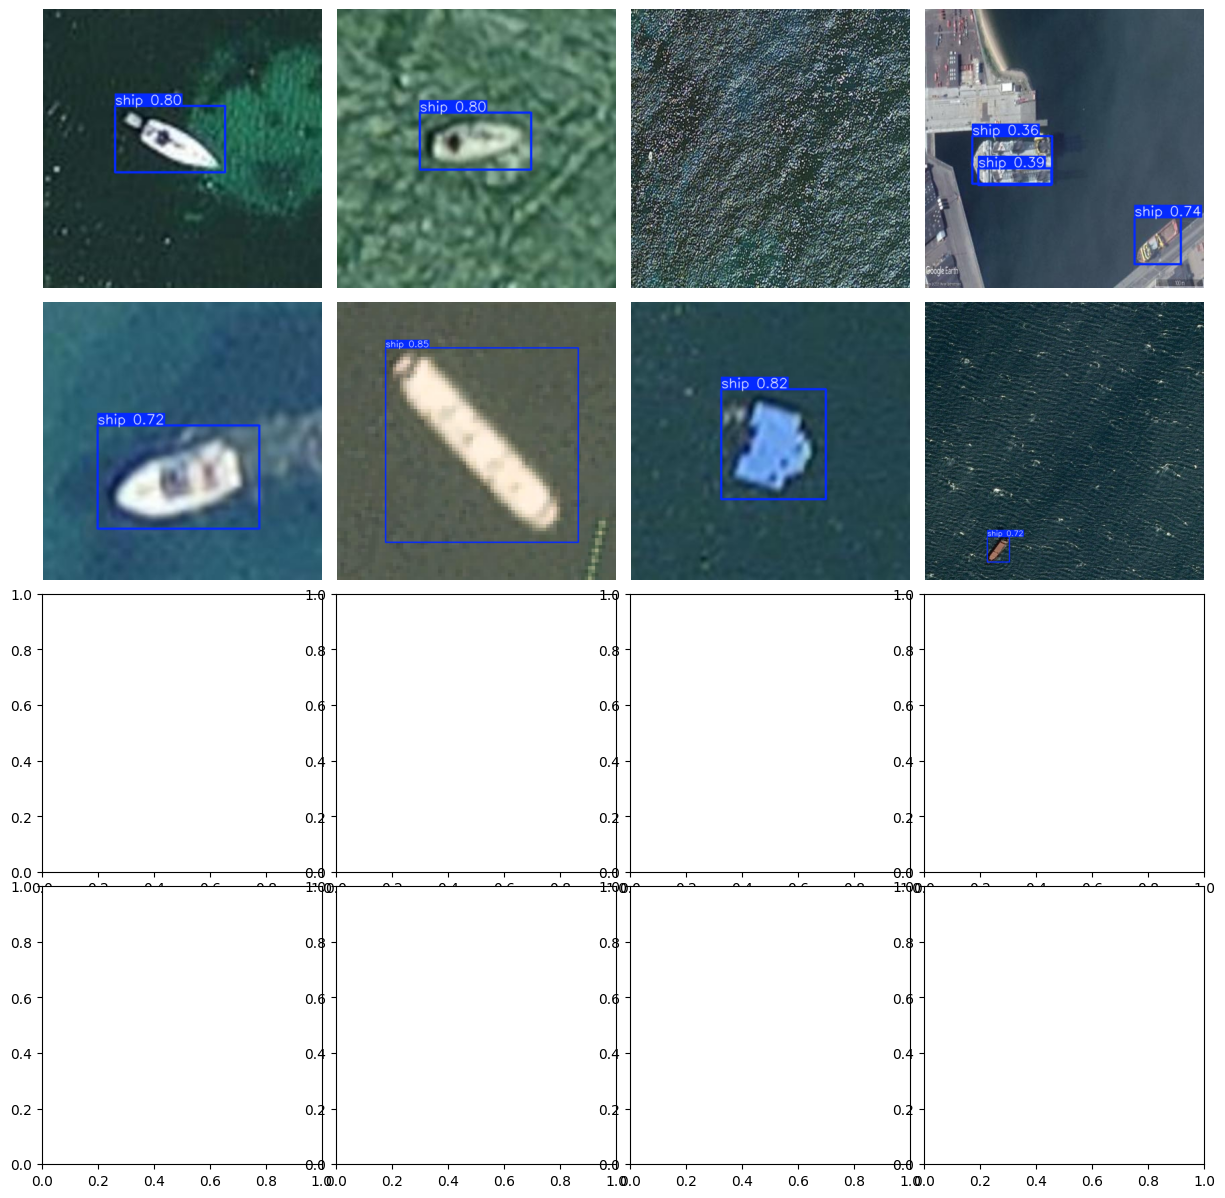

In [15]:
import random

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/ships-in-aerial-images/ships-aerial-images/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 8)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = ship_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)